### What are the most demanded skills for the top 3 most popular data roles?

Methodology:

1. Clean up `job_skills` column
2. Calculate skill counts in the US based on `job_title_short`
3. Calculate % skill
4. Plot final findings


In [1]:
from datasets import load_dataset
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\maitp\anaconda3\envs\PYTHON_PROJECT_1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading up data
dataset = load_dataset("lukebarousse/data_jobs")
df = dataset["train"].to_pandas()

In [3]:
# Cleaning up data
df["job_posted_date"] = pd.to_datetime(df["job_posted_date"])
df["job_skills"] = df["job_skills"].apply(
    lambda job_skill: ast.literal_eval(job_skill) if pd.notna(job_skill) else job_skill
)

In [4]:
# Only get jobs in the US
df_US = df.loc[df["job_country"] == "United States"]
df_US_explode = df_US.explode("job_skills")
df_US_skills_count = df_US_explode.groupby(
    ["job_skills", "job_title_short"], as_index=False
).agg(skill_count=("job_skills", "size"))
df_US_skills_count.sort_values("skill_count", ascending=False, inplace=True)
df_US_skills_count

,job_skills,job_title_short,skill_count
1209,python,Data Scientist,42379
1521,sql,Data Analyst,34452
1523,sql,Data Scientist,30034
455,excel,Data Analyst,27519
1243,r,Data Scientist,26022
...,...,...,...
245,clojure,Software Engineer,1
1738,vb.net,Senior Data Scientist,1
530,fortran,Machine Learning Engineer,1
1116,planner,Cloud Engineer,1


In [5]:
# Get the total count of job postings
df_US_jobs_count = df_US["job_title_short"].value_counts()
df_US_jobs_count

job_title_short
Data Analyst                 67816
Data Scientist               58830
Data Engineer                35080
Senior Data Scientist        12946
Senior Data Analyst          11791
Senior Data Engineer          9289
Business Analyst              7382
Software Engineer             1814
Machine Learning Engineer      921
Cloud Engineer                 423
Name: count, dtype: int64

In [ ]:
# Alternative to adding % skill column
df_US_skills_count["percent"] = df_US_skills_count["skill_count"] / df_US_skills_count[
    "job_title_short"
].map(df_US_jobs_count)

# Another alternative by using .apply() on Series which doesn't require axis parameter
"""
df_US_skills_count["percent"] = df_US_skills_count["skill_count"] / df_US_skills_count[
    "job_title_short"
].apply(lambda row: df_US_jobs_count[row])
"""
df_US_skills_count["percent"]

1209    0.720364
1521    0.508022
1523    0.510522
455     0.405789
1243    0.442325
          ...   
245     0.000551
1738    0.000077
530     0.001086
1116    0.002364
960     0.000108
Name: percent, Length: 1870, dtype: float64

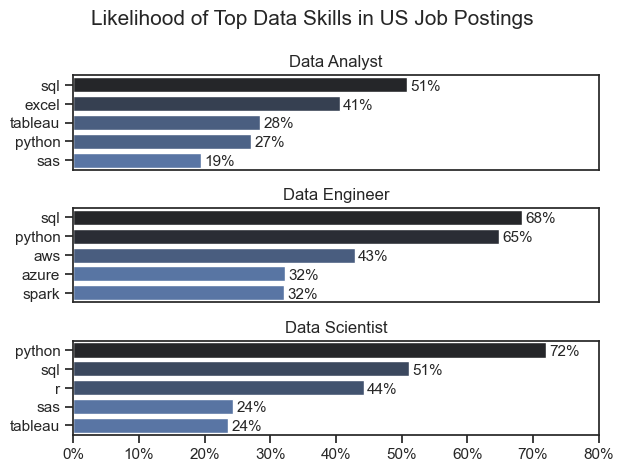

In [9]:
# Only select non-senior data jobs in the US
job_titles = (
    df_US_skills_count["job_title_short"].value_counts().index[:3].sort_values()
)
fig, ax = plt.subplots(len(job_titles), 1)
sns.set_theme(style="ticks")
for i, job_title in enumerate(job_titles):
    df_US_plot = df_US_skills_count.loc[
        df_US_skills_count["job_title_short"] == job_title
    ].head(5)

    df_US_plot["skill_percent"] = (
        df_US_plot["skill_count"] / df_US_jobs_count[job_title]
    )

    sns.barplot(
        data=df_US_plot,
        x="skill_percent",
        y="job_skills",
        ax=ax[i],
        hue="skill_percent",
        palette="dark:b_r",
        legend=None,
    )
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(None)
    ax[i].set_title(job_title)
    ax[i].set_xlim(0, 0.8)
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])
    else:
        ax[i].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x:.0%}"))

    for index, value in enumerate(df_US_plot["skill_percent"]):
        ax[i].text(
            value + 0.005, index, f"{value:.0%}", va="center_baseline", fontsize=11
        )
fig.suptitle("Likelihood of Top Data Skills in US Job Postings", fontsize=15)
fig.tight_layout()